<a href="https://colab.research.google.com/github/ucchol/Machine-Learning-CS--5361/blob/main/Copy_of_%5BSpring_2022%5D_CS_4361_5361_Lab_1_k_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Before you start**

Make a copy of this Colab by clicking on File > Save a Copy in Drive

After making a copy, add your student id, last name, and first name to the title.

In [ ]:
student_name = "Asif Rahman"
student_id = "80741895"

# Classifying Images


This lab is about classifying images. Each input is a grid of pixel values and each output is a label from a small set of labels. You will start with a simple binary classifier and finish with a multi-class one.

### Grading

This assignment is worth a total of 100 points.

In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

## Understanding the data
We'll be using the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. 

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

Before doing anything, let's make sure we understand what we're working with. 

### Load the data
Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [ ]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

np.random.seed(0) # For reproducibility purposes

# Shuffle the order of the training examples.
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

### Basic Analysis
Notice that `X_train`, `Y_train`, `X_test`, and `Y_test` are all numpy arrays. Let's print their shapes to confirm.

In [ ]:
# Show the data shapes.
print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

Notice that there are 60,000 instances in `X_train`. Each of these is a grayscale image represented by an 28-by-28 array of grayscale pixel values between 0 and 255 (the larger the value, the lighter the pixel). Before we continue, let's apply linear scaling to our pixel values, so they all fall between 0 and 1.

In [ ]:
# Pixel values range from 0 to 255. To normalize the data, we just need to 
# divide all values by 255.
X_train = X_train / 255
X_test = X_test / 255

In class, we talked about features - properties that characterize our data. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

Fashion MNIST images have one of 10 possible labels (shown above). Since the labels are indices 0-9, let's keep a list of (string) names for convenience.

In [ ]:
label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Show the first 5 training labels.
print('First 5 label values:', Y_train[0:5])
print('Mapped to their names:', [label_names[i] for i in Y_train[0:5]])


Next let's use the `imshow` function to look at the first few images in the training set.

In [ ]:
# Create a figure with subplots. This returns a list of object handles in axs
# which we can use populate the plots.
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_train[i]
  label = Y_train[i]
  label_name = label_names[label]
  axs[i].imshow(image, cmap='gray')  # imshow renders a 2D grid
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()

#### Exercise 1

Display the first 5 images for each class in a 10x5 grid. Feel free to use the code above to get started. Here's a [link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) to matplotlib's documentation. 

In [ ]:
# Your code goes here
fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(10,10))
for i in range(10):
  j=0
  for k in range(len(Y_train)):
    if(i == Y_train[k]):
      image = X_train[k]
      label = Y_train[k]
      label_name = label_names[label]
      axs[i, j].imshow(image, cmap='gray')  # imshow renders a 2D grid
      axs[i, j].set_title(label_name)
      axs[i, j].axis('off')
      j += 1
      if(j == 5): break
plt.show()

## Problem Definition: Sneaker Classifier
There are many things we can do with this dataset. Following our lectures, let's start with binary classification. We'll use the k-nearest neighbors (k-NN) algorithm described in class to build a sneaker classifier. Our positive examples ($y=1$) will be sneaker images (class 7) and our negative examples ($y=0$) will be all other images.

The idea is that our k-NN model, given an image $x$, will produce $\hat{y}$, the probability that $x$ is a sneaker.

### Instance Based Learning

Instance-based learning is often termed lazy learning, as there is typically no “transformation” of training instances into more general
representations

Instead, the presented training data are simply stored and, when a new
query instance is encountered, a set of similar, related instances is
retrieved from memory and used to classify the new query instance

Hence, instance-based learners never form an explicit general hypothesis
regarding the target function. They simply compute the classification of
each new query instance as needed

#### K-Nearest Neighbors

The simplest, most used instance-based learning algorithm is the k-nearest neighbors algorithm. 

k-NN assumes that all instances are points in some n-dimensional space and defines neighbors in terms of distance (usually Euclidean in R-space), where k is the number of neighbors considered.

Properties:
1) All possible points within a sample's Voronoi cell are the nearest neighboring points for that sample
2) For any sample, the nearest sample is determined by the closest Voronoi cell
edge


##### Graphic Depiction

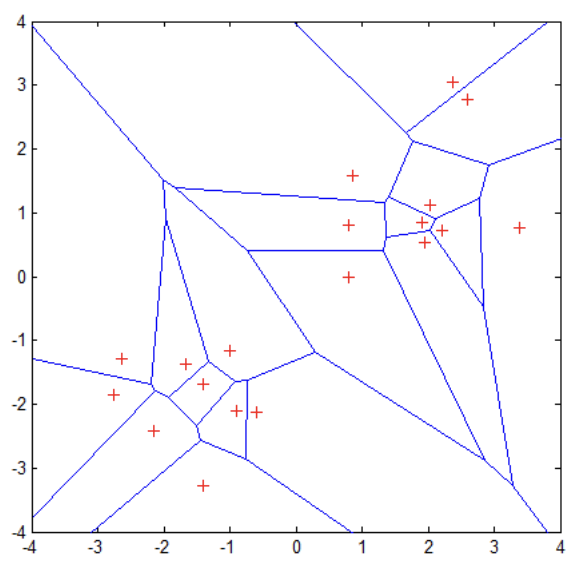

Using the second property, the k-NN classification rule is to assign to
a test sample the majority category label of its k nearest training
samples
In practice, k is usually chosen to be odd, so as to reduce the
probability of ties
The k = 1 rule is generally called the nearest-neighbor classification
rule. 

### Data Preprocessing
Before we continue, we need to prepare the data for this binary classification task. We'll map sneaker image laebls to 1 (the positive class) and all other images to 0 (the negative class).

Programming note: Numpy allows us to perform what is called [boolean array indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#boolean-array-indexing)
This means that a numpy array $A$ can be indexed using a boolean array $B$
as follows: $A[B]$.
We'll take advantage of this type of indexing to prepare the labels for our binary classification task below.

In [ ]:
# Make copies of the original labels.
Y_train_binary = np.copy(Y_train)
Y_test_binary = np.copy(Y_test)

# Update labels: 1 for sneaker images; 0 for the rest.
# Note that a boolean array is created when Y_train_binary != 7 is evaluated.
Y_train_binary[Y_train_binary != 7] = 0.0 
Y_train_binary[Y_train_binary == 7] = 1.0
Y_test_binary[Y_test_binary != 7] = 0.0
Y_test_binary[Y_test_binary == 7] = 1.0
# Cool, right?

#### Exercise 2 

Let's briefly investigate some statistical differences between sneaker and non-sneaker images.

1.   Find all sneaker images in `X_train` and compute the mean and standard deviation of the center pixel value across all **sneaker** images. The center pixel is located at position [14, 14].

2.   Find all non-sneaker images in `X_train` and compute the mean and standard deviation of the center pixel values across all **non-sneaker** images. The center pixel is located at position [14, 14].

3. Repeat 1 and 2 for the pixel located at positon [3, 14].

In [ ]:
X_train_sneaker = X_train[Y_train==7]
X_train_nonsneaker = X_train[Y_train!=7]
sneaker_mean_14_14 = np.mean(X_train_sneaker[14, 14, 14])
sneaker_std_14_14 = np.std(X_train_sneaker[:, 14, 14])
nonsneaker_mean_14_14 = np.mean(X_train_nonsneaker[:, 14, 14])
nonsneaker_std_14_14 = np.std(X_train_nonsneaker[:, 14, 14])
print("Sneaker mean at 14, 14: ", sneaker_mean_14_14)
print("Sneaker standard deviation at 14, 14: ", sneaker_std_14_14)
print("Non-sneaker mean at 14, 14: ", nonsneaker_mean_14_14)
print("Non-sneaker standard deviation at 14, 14: ", nonsneaker_std_14_14)

sneaker_mean_3_14 = np.mean(X_train_sneaker[:, 3, 14])
sneaker_std_3_14 = np.std(X_train_sneaker[:, 3, 14])
nonsneaker_mean_3_14 = np.mean(X_train_nonsneaker[:, 3, 14])
nonsneaker_std_3_14 = np.std(X_train_nonsneaker[:, 3, 14])
print("Sneaker mean at 3, 14: ", sneaker_mean_3_14)
print("Sneaker standard deviation at 3, 14: ", sneaker_std_3_14)
print("Non-sneaker mean at 3, 14: ", nonsneaker_mean_3_14)
print("Non-sneaker standard deviation at 3, 14: ", nonsneaker_std_3_14)


### Baseline

When dealing with classification problems, a simple, but useful baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

Our training dataset consists of 6,000 sneaker examples (10%), and 54,000 non-sneaker images (90%), so our majority class baseline classifies everything as *non-sneaker*, and will have an accuracy of 90%. We will see if we can beat this baseline with k-NN.

In [ ]:
print('Number of sneaker images in training set:', (Y_train_binary == 1).sum())
print('Number of non-sneaker images in training set:', (Y_train_binary == 0).sum())

### k-NN Implementation

Every image in our dataset is represenyed by an 28-by-28 array (2D). To make things easier, let's *flatten* X_train and X_test so each image is represented by an array (1D) of size 784 (28*28). 

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
print(X_train.shape)
print(X_test.shape)


#### Exercise 3 

Implement the **weighted** version of knn using the following algorithm:





##### k-NN algorithm (binary classification)


```
Input: X_train, Y_train, X_test, k (number of neighbors)
Output: pred - the predicted probability for each example in x_test to be a member of the positive class

for every example x_i in x_test:
    find the distance from x_i to every instance in x_train
    find the k examples in x_train with smallest distance to x_i (the k-nearest neighbors)
    pred[i] = number of positive neighbors / k (unweighted)
    or
    pred[i] = w_neighbor_1 * y_neighbor_1 + ... + w_neighbor_k * y_neighbor_k (weighted)
    where w_neighbor_1 + ... + w_neighbor_k = 1 and the weight assigned to a
    neighbor is inversely proportional to its distance to x_i 

```


In [ ]:
# Feel free to add as many helper functions as you'd like

def knn(X_train, Y_train_binary, Y_test, k):
  pred = np.zeros(X_test.shape[0]) # Feel free to change / remove this line
  
  # Your code here

  return pred

### Evaluation
To turn probabilities into binary predictions, we need to choose a classification threshold. A probability greater than or equal to threshold indicates class *sneaker*, while a value less than the threshold indicates class *non-sneaker*. Once we have binary predictions, we can evaluate performance with some different metrics.

A **true positive** is an outcome where the model correctly predicts the positive class. Similarly, a **true negative** is an outcome where the model correctly predicts the negative class.

A **false positive** is an outcome where the model incorrectly predicts the positive class. And a **false negative** is an outcome where the model incorrectly predicts the negative class.

Using these, we can construct a **confusion matrix**, a table that summarizes performance using these 4 result categories.

|                     | Sneaker (Actual)    | Non-Sneaker (Actual) |
|---------------------|-----------------|------------------|
| **Sneaker (Predicted)**     | Number of True Positives  | Number of False Positives  |
| **Non-Sneaker (Predicted)** | Number of False Negatives | Number of True Negatives   |


**Accuracy** is the fraction of examples our model classified correctly (correct / total):

\begin{equation}
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation}

**Precision** is the proportion of positive predictions that were actually correct:

\begin{equation}
Precision = \frac{TP}{TP + FP}
\end{equation}

**Recall** is the proportion of actual positives that were predicted correctly:

\begin{equation}
Recall = \frac{TP}{TP + FN}
\end{equation}

Changing the threshold will change precision and recall, typically with a trade-off: improving precision reduces recall (and vice-versa).

#### Exercise 4


Test your implementation of knn using k=5. Then, do the following for each of these classification thresholds [0.1, 0.3, 0.5, 0.7, 0.9] using `pred` (predicted probabilities) and `Y_test_binary` (actual labels):

1.   Compute and print counts of [tp, tn, fp, fn]
2.   Compute and print the accuracy, precision, and recall.

**You are not allowed to use other libraries that might do this for you. You may only use numpy**

In [ ]:
# Your code goes here

### Analyze Classification Mistakes

Our predictions are not perfect. Regardless of the classification threshold we choose, it misclassifies some images. Let's take a look at some of the images that our model misclassified.

#### Exercise 5

1.   Display 5 images that were erroneously classified as sneaker (threshold = 0.5).
2.   Display 5 images that were erroneously classified as non-sneaker (threshold = 0.5).

You may want to reshape X_test so you can display the images `X_test = X_test.reshape(X_test.shape[0],28,28)`


In [ ]:
# Your code goes here

## Multiclass Classification

We are now ready for the full multi-class case. Instead of using `Y_train_binary` and `Y_test_binary`, we'll use the original labels `Y_train` and `Y_test`. 



#### Exercise 6 

Re-implement knn using the following algorithm:

```
Input: x_train, y_train, x_test, k
Output: pred - the predicted class for every example in x_test

for every example x_i in x_test:
    find the distance from x_i to every instance in x_train
    find the k examples in x_train with smallest distance to x_i (the k-nearest neighbors)
    pred[i] = most common value of y in the selected k neighbors
```

Notice how `pred` contains actual class predictions instead of probabilities. 


In [ ]:
# Feel free to add as many helper functions as you'd like
def knn_multiclass(X_train, Y_train, Y_test, k):
  pred = np.zeros(X_test.shape[0]) # Feel free to change / remove this line
  
  # Your code here

  return pred


#### Exercise 7

Test your implementation of knn_multiclass using at least 5 different values for k. For each of those values, compute the accuracy of your model and display the confusion matrix (feel free to use sklearn). 


```
Accuracy = number of instances where Y_test[i] == pred[i] divided by total number of test instances.
```

In [ ]:
# Your code goes here

## Submission Instructions

1. File > Download .ipynb
2. Go to Blackboard, find the submission page, and upload the .ipynb file you just downloaded.

In [ ]:
89.92/3


In [ ]:
7.49*2+ 4.99 + 13.96

In [ ]:
4.99+ 24.49+10.99

In [ ]:
(20.94/3)*2